# Codeup Individual Project: Predicting Vehicle Accident Severity

The purpose of this project is to analyze the selected dataset, answer questions regarding the data, and develop a machine learning model to predict the severity of an accident based on human and environmental circumstances. I obtained the dataset for this project from https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents?resource=download.

I am using this dataset for academic purposes only.

Initial Questions:

- What road conditions are most likely to result in an accident?
- What time of day are accidents most likely to occur? What time of year are accidents most likely to occur?
- Are there specific areas that are prone to crashes?

Questions regarding time:

- Have the number of accidents increased overall between 2016 and 2021?
- Has the severity of accidents changed between 2016 and 2021?

## Project Utility

- Predicting accident severity based on environmental conditions and road features can be useful for first responders, drivers, and rideshare companies. Accurate predictions can help first responders gauge the amount of services and emergency aid needed based on the most commonly required responses for each level of severity. Drivers can get accurate updates on how long traffic will be delayed and if alternate routes are needed. Future utility includes providing warnings to drivers and first responders of potential accident locations and severity based on current environmental and road conditions.


## Executive Summary

- The dataset was downsampled using random sampling due to an imbalance in the target variable. I split the downsampled data into train, validate, and test using a 60/20/20 split stratefied on severity. The total number of observations after removing nulls and outliers and downsampling was 191,685.
- The selected model is a random forest classifier with a depth of 16 and minimum sample leaf size of 35. I selected 23 features for the final model based on visualizations and statistical tests. I used a random_seed of 217 for reproducibility. The baseline prediction for the training set was .34. The model performed above baseline accuracy at .71 on train and .69 on validate, indicating that the decision tree was not overfit. The model scored .69 on the test set as well. The model was 34 percent more accurate than baseline on the validate and test sets.


## Acquisition and Preparation

- Acquire the dataset from Kaggle and save to a local csv
- Prepare the data with the intent to discover the main predictors of crash severity; clean the data and encode categorical features if necessary; ensure that the data is tidy
- Write functions to wrangle the data and save to wrangle.py

In [1]:
# required imports for the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import explore
import wrangle
import model
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
import warnings
warnings.filterwarnings("ignore")

In [2]:
# acquire the dataset using wrangle.py file
df = wrangle.wrangle_data()

In [3]:
# verify dataset was wrangled successfully
df.head(3)

,id,severity,start_time,end_time,start_lat,start_lng,end_lat,end_lng,distance,description,...,railway,roundabout,station,stop,traffic_calming,traffic_signal,sunrise_sunset,civil_twilight,nautical_twilight,astronomical_twilight
0,A-1,3,2016-02-08 00:37:08,2016-02-08 06:37:08,40.108910,-83.092860,40.112060,-83.031870,3.230,Between Sawmill Rd/Exit 20 and OH-315/Olentang...,...,0,0,0,0,0,0,1,1,1,1
4,A-5,3,2016-02-08 07:53:43,2016-02-08 13:53:43,39.172393,-84.492792,39.170476,-84.501798,0.500,At Mitchell Ave/Exit 6 - Accident.,...,0,0,0,0,0,0,0,0,0,0
7,A-8,2,2016-02-08 11:51:46,2016-02-08 17:51:46,41.375310,-81.820170,41.367860,-81.821740,0.521,At Bagley Rd/Exit 235 - Accident.,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# downsample severity level 2 to balance the dataset, drop severity level 1
df = wrangle.downsample_data(df)

In [5]:
# create a new column for the year the accident occurred
df['year'] = df.start_time.dt.year
# create a new column for the month the accident occurred
df['month'] = df.start_time.dt.month
# create a new column for the day of the month the accident occurred
df['day'] = df.start_time.dt.day
# create a new column for the hour of the day the accident occurred
df['hour'] = df.start_time.dt.hour

In [6]:
# verify that all columns are present and there are no null values
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191685 entries, 1250474 to 2845328
Data columns (total 47 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   id                     191685 non-null  object        
 1   severity               191685 non-null  int64         
 2   start_time             191685 non-null  datetime64[ns]
 3   end_time               191685 non-null  datetime64[ns]
 4   start_lat              191685 non-null  float64       
 5   start_lng              191685 non-null  float64       
 6   end_lat                191685 non-null  float64       
 7   end_lng                191685 non-null  float64       
 8   distance               191685 non-null  float64       
 9   description            191685 non-null  object        
 10  street                 191685 non-null  object        
 11  side                   191685 non-null  object        
 12  city                   191685 non-nul

### Acquisition and Preparation Takeaways

- Four columns have been dropped: number, country, airport_code, and turning_loop. These columns are not necessary or useful for analysis at this time.
- All observations with null values were dropped.
- Outliers for wind_speed and wind_chill were dropped, and total_time was limited to accidents with a duration of one day or less.
- The final dataset has 191,685 observations. The target variable has been reduced from 4 categories to 3. One category was dropped because the observations all occurred within a 9-month span during the beginning of the Covid-19 pandemic.

## Exploratory Data Analysis

- Explore the data:
    - Univariate, bivariate, and multivariate analyses; statistical tests for significance, find the three primary features affecting crash severity; use distance, precipitation, and visibility for the first model
- Create graphical representations of the analyses
- Answer initial questions

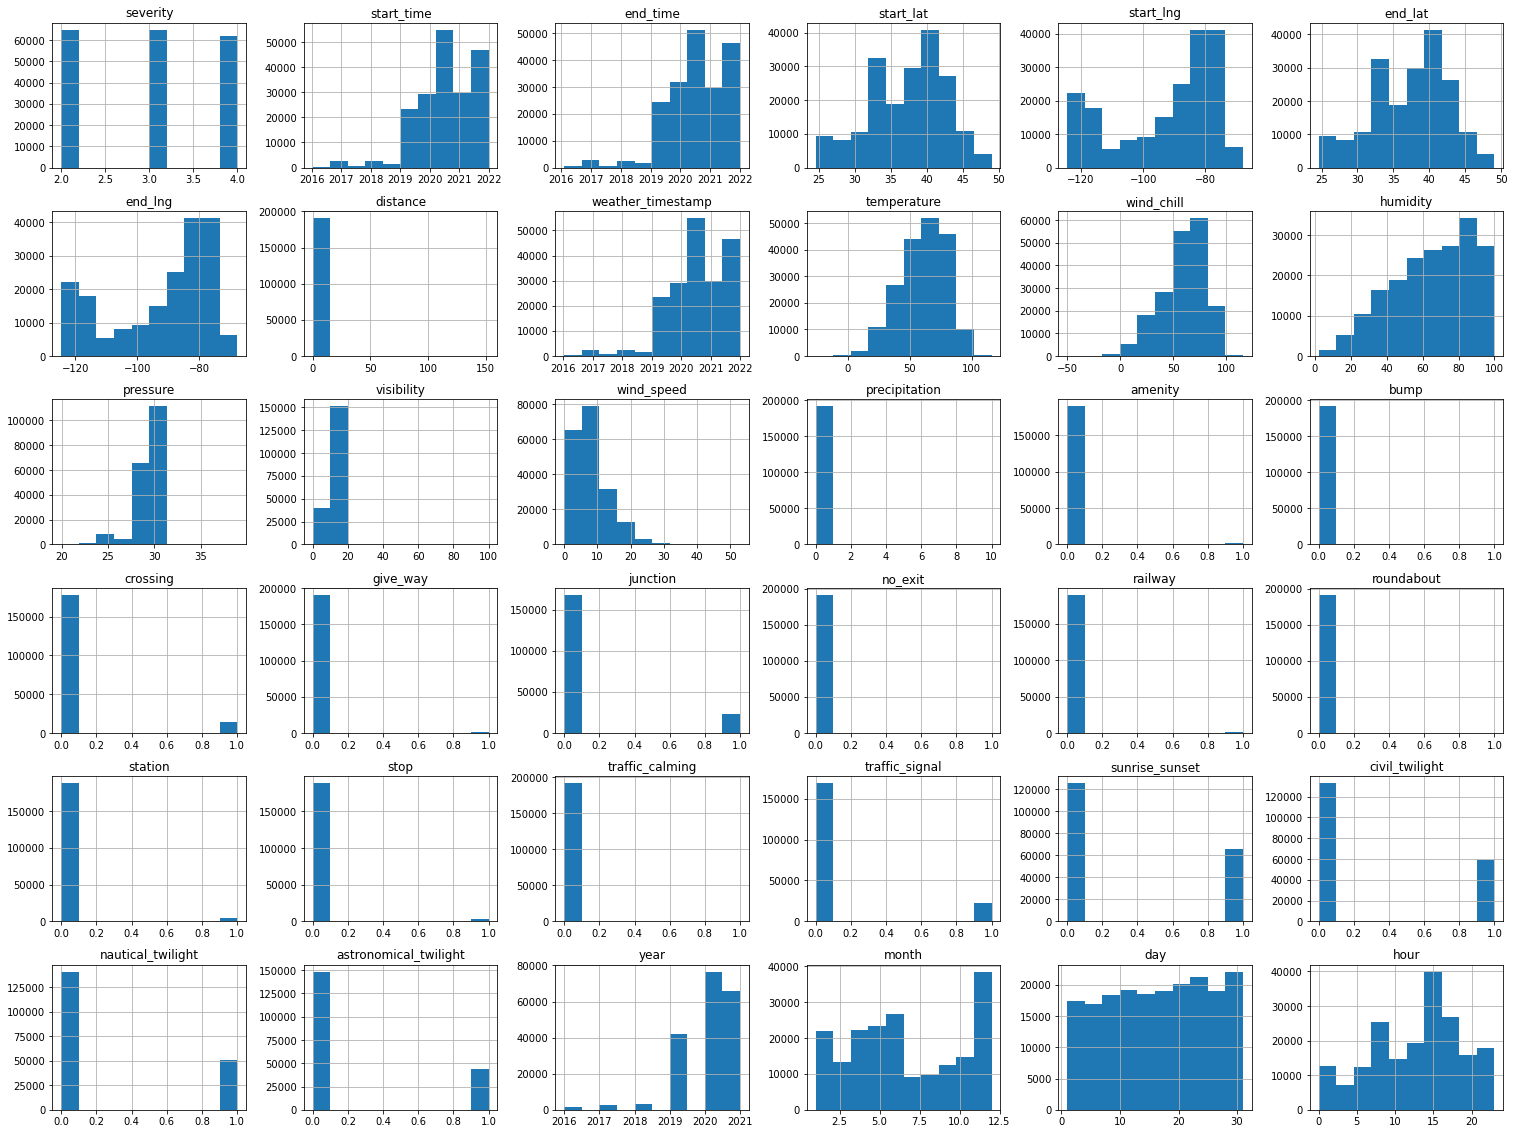

In [7]:
# histograms of each feature and the target variable
df.hist(figsize=[26,20])
plt.show()

In [8]:
# split the dataset using a 60/20/20 split, stratified on the target variable
train, validate, test = explore.split_data(df, 'severity')

In [9]:
# verify the data was split correctly
train.shape, validate.shape, test.shape

((115011, 47), (38337, 47), (38337, 47))

#### Are accidents more likely to occur during the day or at night?

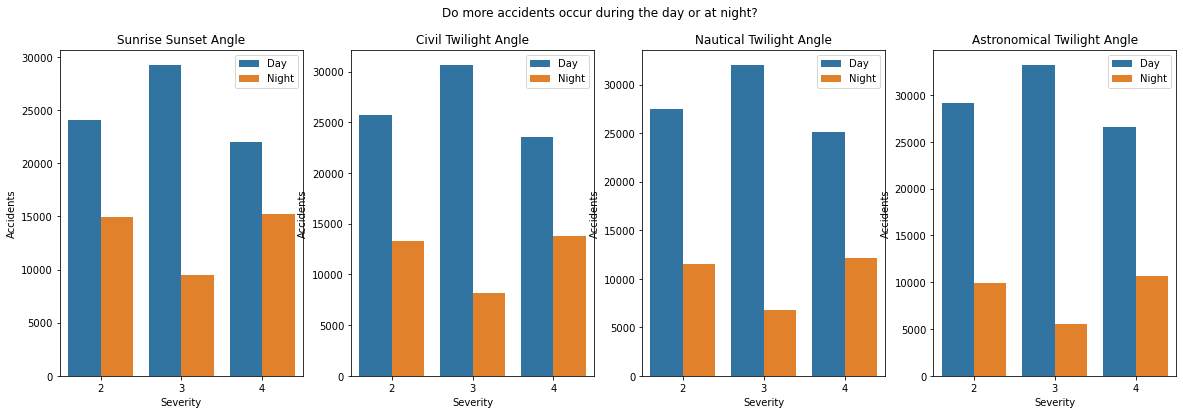

In [10]:
# plot graphs for the relationship between day/night and accident severity
explore.plot_day_night(train)

Statistical test for independence between severity and sunrise_sunset:
- H0: There is no association between the severity of an accident and whether it is day or night.
- Ha: There is an association between the severity of an accident and whether it is day or night.

In [11]:
# conduct a chi2 test of independence for sunrise_sunset and severity
explore.stat_chi2(train.severity, train.sunrise_sunset)

Observed
[[24105 14895]
 [29222  9526]
 [22024 15239]]

Expected
[[25551 13448]
 [25386 13361]
 [24413 12849]]

----
chi^2 = 2596.2436
p     = 0.0
We reject the null hypothesis of independence.


- Crashes occur more often during the day, but there is generally more traffic during daytime hours. An interesting finding is that accidents that occur more frequently during nighttime on the sunrise_sunset angle than on the other angles. This may be because sunlight is still visible when the sun reaches the sunrise_sunset angle, but visibility is reduced during this particular time period.

#### Are there specific areas that are prone to crashes?

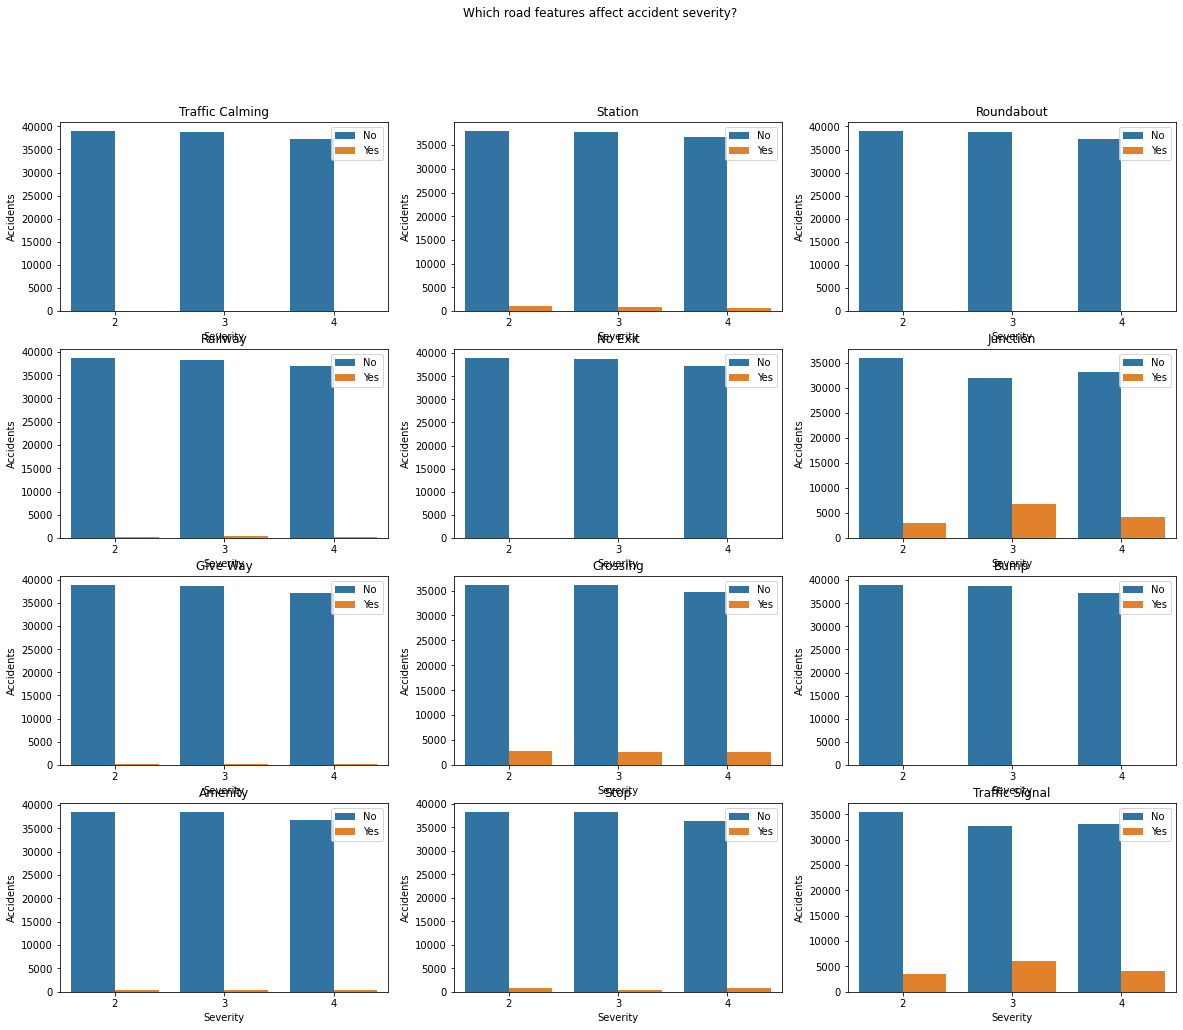

In [12]:
# plot the relationships between individual road features and accident severity
explore.countplot_data(train)

- Most of the accidents occurred when these particular features were NOT present, but there are certain features, such as traffic signals, crossings, and junctions, where accidents occur more often.

#### What road and environmental conditions are most likely to result in an accident?

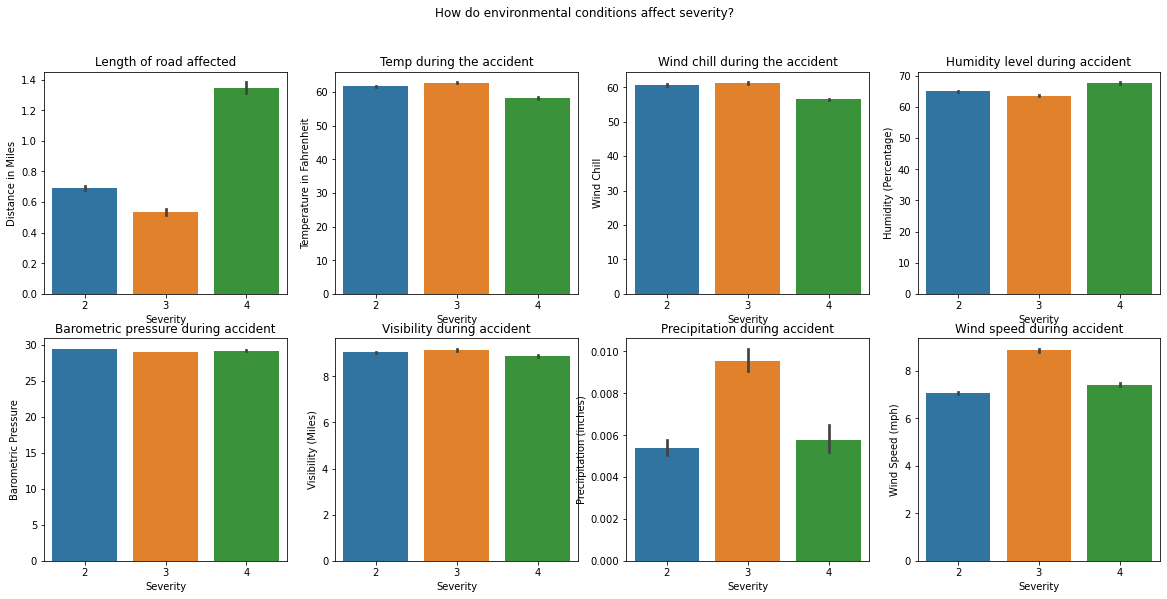

In [13]:
# plot the relationships between environmental conditions and accident severity
explore.barplot_data(train)

- Severe accidents tend to cover more distance that moderate crashes. Precipitation seems to have an effect on the severity of a crash. Wind speed also appears to play a role in crash severity.

Statistical test for severity and distance:
- H0: There is no mean difference of accident distance between the three severity categories.
- Ha: There is a mean difference of accident distance between the three severity categories.

In [14]:
# create variables for distance based on severity levels
sev2_dist = train[train.severity==2]['distance']
sev3_dist = train[train.severity==3]['distance']
sev4_dist = train[train.severity==4]['distance']

In [15]:
# test for equal variance between severity 2 distance and severity 3 distance
explore.stat_levene(sev2_dist, sev3_dist)

we can reject the null hypothesis and posit that variance is inequal


In [16]:
# test for equal variance between severity 2 distance and severity 4 distance
explore.stat_levene(sev2_dist, sev4_dist)

we can reject the null hypothesis and posit that variance is inequal


In [17]:
# test for equal variance between severity 3 distance and severity 4 distance
explore.stat_levene(sev3_dist, sev4_dist)

we can reject the null hypothesis and posit that variance is inequal


In [18]:
# use the Kruskal-Wallis one-way analysis of variance for nonparametric data
explore.stat_kruskal(sev2_dist, sev3_dist, sev4_dist)

we can reject the null hypothesis that there is no mean difference.
H: 10706.016862801565, p-value: 0.0


Statistical test for severity and precipitation:
- H0: There is no mean difference in precipitation between the three severity categories.
- Ha: There is a mean difference in precipitation between the three severity categories.

In [19]:
# create variables for precipitation for each severity level
sev2_rain = train[train.severity==2]['precipitation']
sev3_rain = train[train.severity==3]['precipitation']
sev4_rain = train[train.severity==4]['precipitation']

In [20]:
# test for equal variance between severity 2 precipitation and severity 3 precipitation
explore.stat_levene(sev2_rain, sev3_rain)

we can reject the null hypothesis and posit that variance is inequal


In [21]:
# test for equal variance between severity 2 precipitation and severity 4 precipitation
explore.stat_levene(sev2_rain, sev4_rain)

we fail to reject the null hypothesis that variance is equal


In [22]:
# test for equal variance between severity 4 precipitation and severity 3 precipitation
explore.stat_levene(sev4_rain, sev3_rain)

we can reject the null hypothesis and posit that variance is inequal


In [23]:
# use the Kruskal-Wallis one-way analysis of variance for nonparametric data
explore.stat_kruskal(sev2_rain, sev3_rain, sev4_rain)

we can reject the null hypothesis that there is no mean difference.
H: 482.3506995938268, p-value: 1.8149990920366762e-105


Statistical test for severity and visibility:
- H0: There is no mean difference in visibility between the three severity categories.
- Ha: There is a mean difference in visibility between the three severity categories.

In [24]:
# create variables for visibility for each severity level
sev2_vis = train[train.severity==2]['visibility']
sev3_vis = train[train.severity==3]['visibility']
sev4_vis = train[train.severity==4]['visibility']

In [25]:
# test for equal variance between severity 2 visibility and severity 3 visibility
explore.stat_levene(sev2_vis, sev3_vis)

we can reject the null hypothesis and posit that variance is inequal


In [26]:
# test for equal variance between severity 2 visibility and severity 4 visibility
explore.stat_levene(sev2_vis, sev4_vis)

we can reject the null hypothesis and posit that variance is inequal


In [27]:
# test for equal variance between severity 4 visibility and severity 3 visibility
explore.stat_levene(sev4_vis, sev3_vis)

we can reject the null hypothesis and posit that variance is inequal


In [28]:
# use the Kruskal-Wallis one-way analysis of variance for nonparametric data
explore.stat_kruskal(sev2_vis, sev3_vis, sev4_vis)

we can reject the null hypothesis that there is no mean difference.
H: 34.845281495686336, p-value: 2.7129592033858515e-08


#### What time of day are accidents most likely to occur? What time of year are accidents most likely to occur?

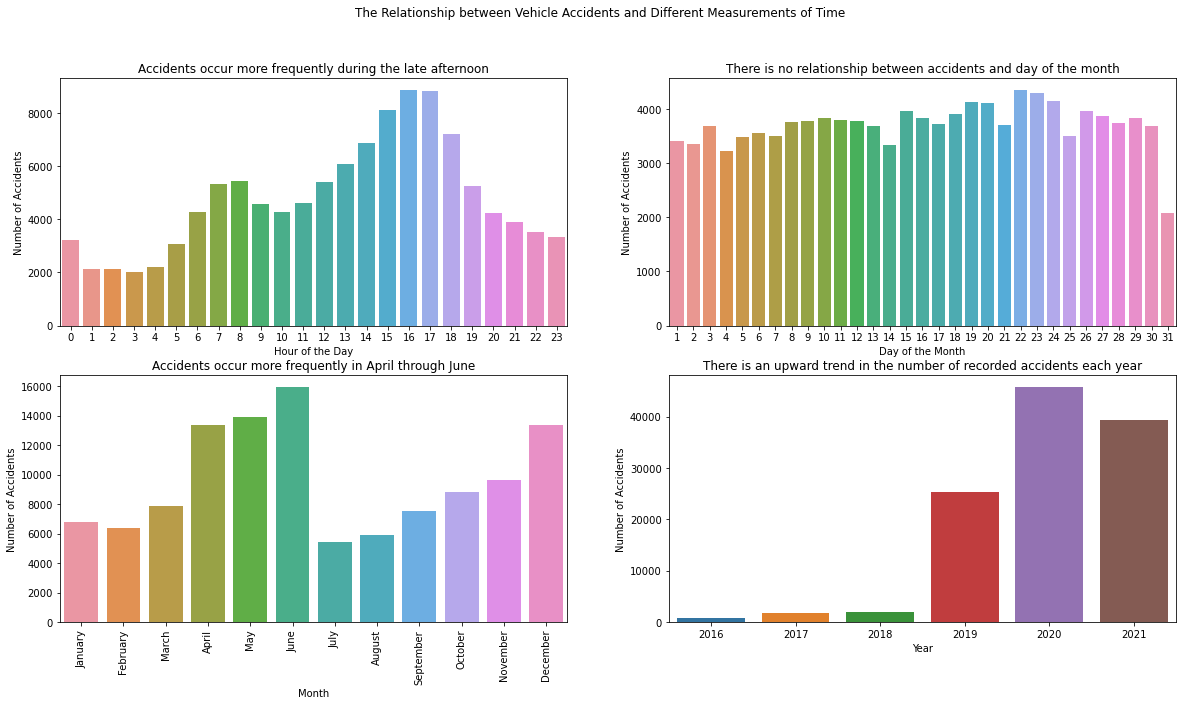

In [29]:
# plot number of accidents based on different measurements of time
explore.plot_time_data(train)

- Accidents increase from April to June, and increase again in December. This coincides with periods where children are out of school and families are traveling. These months tend to have more precipitation in certain regions as well.
- Accidents appear to occur most frequently during afternoon rush-hour traffic, when most people are traveling home from work or school.

### Exploration Takeaways

Initial exploration: 

- The target variable caused the dataset to be unbalanced, as most accidents were classified as severity level 2. This resulted in a baseline accuracy using the mode to be 93 percent. In order to balance the dataset, I took a random sample of 65,000 level-2 severity accidents from the total dataset using random_seed=217 for reproducibility. I concatenated this sample with the total observations from the other severity classes into a new dataframe. This sampling did not take into account any features, so important data about key features of a crash may have been lost.

Time exploration:

- When resampling for start_time, additional visualization indicated that more accidents occur in April through June, and between the hours of 2pm and 6pm. Perhaps using start time as a feature will improve the models' performance. The number of accidents has increased year over year, but this may be due to improved data collection and digitized accident information over the years. 

Statistical exploration:

- Statistical testing using a Kruskal-Wallis one-way analysis of variance showed significant differences in the three initial features selected for modeling (precipitation, visibility, and distance). Chi^2 test of severity and whether it is day or night (according to sunrise/sunset angle) showed an association.


## Modeling

- Train and test four models:
    - Establish a baseline using the mode for severity
    - Select key features and train multiple classification models (Decision Tree, Random Forest, KNN, Logistic Regression)
    - Test the model on the validate set, adjust for overfitting if necessary

In [30]:
# find the most observed severity level
train.severity.mode()

0    2
Name: severity, dtype: int64

In [31]:
# establish a baseline prediction using the mode
baseline = len(train[train.severity==2]) / len(train)
baseline

0.339097999321804

In [32]:
# select significant features for modeling based on visualization and statistical testing
cols = ['distance','precipitation','visibility','humidity','temperature','pressure','wind_speed','amenity','bump', 
       'crossing','give_way','junction','no_exit','railway','roundabout','station','stop','traffic_calming',
       'traffic_signal','sunrise_sunset','year','month', 'hour']
# create the dataframes for train features and target
X_train, y_train = train[cols], train.severity
# create the dataframes for validate features and target
X_validate, y_validate = validate[cols], validate.severity
# create the dataframes for test features and target
X_test, y_test = test[cols], test.severity

#### Decision Tree Model, Depth = 8

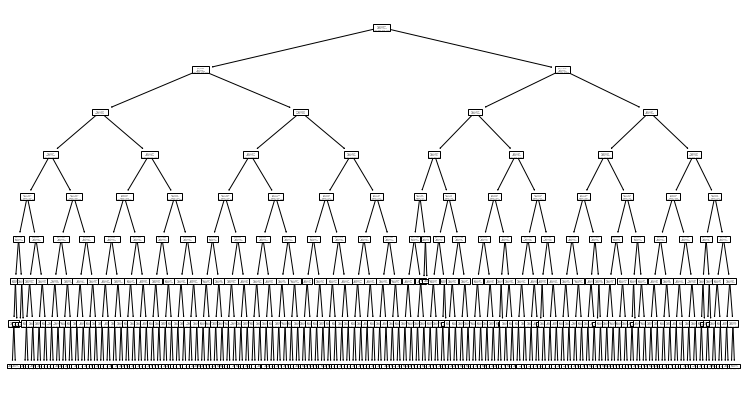

Accuracy of Decision Tree classifier on training set: 0.68
              precision    recall  f1-score   support

           2       0.72      0.79      0.75     39000
           3       0.68      0.86      0.76     38748
           4       0.60      0.38      0.46     37263

    accuracy                           0.68    115011
   macro avg       0.67      0.68      0.66    115011
weighted avg       0.67      0.68      0.66    115011

Accuracy of Decision Tree classifier on validate set: 0.67


In [33]:
# decision tree model function from model.py with a selected depth of 8
model.tree_model(X_train, y_train, X_validate, y_validate, 8)

#### Random Forest Model

In [34]:
# random forest function from model.py with a depth of 16 and 35 sample leaf size
model.rand_forest(X_train, y_train, X_validate, y_validate, 16, 35)

Accuracy of Random Forest classifier on training set: 0.71
              precision    recall  f1-score   support

           2       0.71      0.86      0.78     39000
           3       0.72      0.86      0.78     38748
           4       0.69      0.38      0.49     37263

    accuracy                           0.71    115011
   macro avg       0.70      0.70      0.68    115011
weighted avg       0.70      0.71      0.69    115011

Accuracy of Random Forest classifier on validate set: 0.69


#### K Nearest Neighbors Model, Scaled, n=40

In [35]:
# make the object, put it into the variable scaler
scaler = MinMaxScaler()
# fit the object to my data:
X_train_scaled = scaler.fit_transform(X_train)
X_validate_scaled = scaler.transform(X_validate)

In [36]:
# knn model function from model.py with 40 neighbors
model.knn_model(X_train_scaled, y_train, X_validate_scaled, y_validate, 40)

Accuracy of KNN on training set: 0.66
Accuracy of KNN on validate set: 0.63


#### Logistic Regression Model

In [37]:
# logistic regression model function from model.py 
model.log_model(X_train, y_train, X_validate, y_validate)

Logistic Regression using selected features
Accuracy of Logistic Regression classifier on training set: 0.50
              precision    recall  f1-score   support

           2       0.51      0.60      0.55     39000
           3       0.49      0.72      0.59     38748
           4       0.48      0.16      0.24     37263

    accuracy                           0.50    115011
   macro avg       0.49      0.49      0.46    115011
weighted avg       0.49      0.50      0.46    115011

Accuracy of Logistic Regression classifier on validate set: 0.50


In [38]:
# logistic regression model using scaled data
model.log_model(X_train_scaled, y_train, X_validate_scaled, y_validate)

Logistic Regression using selected features
Accuracy of Logistic Regression classifier on training set: 0.60
              precision    recall  f1-score   support

           2       0.68      0.75      0.71     39000
           3       0.62      0.78      0.69     38748
           4       0.44      0.27      0.33     37263

    accuracy                           0.60    115011
   macro avg       0.58      0.60      0.58    115011
weighted avg       0.58      0.60      0.58    115011

Accuracy of Logistic Regression classifier on validate set: 0.61


### Modeling Takeaways

- The Decision Tree Classifier with a depth of 8 had a 68 percent accuracy on the training set and a 67 percent accuracy on validate. The model had high F1-scores for severity levels 2 and 3, but struggled to accurately predict level 4. This model provided a 33 percent increase in accuracy above the baseline.

- The Random Forest Model with a depth of 16 and minimum sample leaf of 35 had a 71 percent accuracy on train and 69 percent accuracy on validate. This model has the most potential for tuning with hyperparameters and feature engineering. Random Forest was 34 percent more accurate on validate than the baseline prediction.

- The K Nearest Neighbors Model with 40 neighbors had an accuracy of 65 percent on train and 63 percent on validate. The features were scaled prior to training the model. The model was 29 percent more accurate than baseline.

- The Logistic Regression Model had a 60 percent accuracy on train and 61 percent on validate using scaled data. The accuracy was 49 percent on train and validate with unscaled data. This model was not tuned and may perform better with specific arguments and fine tuning. The model was 26 percent more accurate than baseline.

- I will use the Random Forest model for testing because it performed best on precision, accuracy, and recall. 

## Test the Best Model

In [39]:
# random forest model was selected; test the model using a function from model.py
model.test_forest(X_train, y_train, X_test, y_test, 16, 35)

Accuracy of Random Forest classifier on training set: 0.71
              precision    recall  f1-score   support

           2       0.71      0.86      0.78     39000
           3       0.72      0.86      0.78     38748
           4       0.69      0.38      0.49     37263

    accuracy                           0.71    115011
   macro avg       0.70      0.70      0.68    115011
weighted avg       0.70      0.71      0.69    115011

Accuracy of Random Forest classifier on test set:     0.69
              precision    recall  f1-score   support

           2       0.70      0.85      0.77     13000
           3       0.70      0.85      0.77     12916
           4       0.65      0.35      0.46     12421

    accuracy                           0.69     38337
   macro avg       0.68      0.69      0.66     38337
weighted avg       0.68      0.69      0.67     38337



## Conclusions, Recommendations, and Next Steps



- The target variable caused the dataset to be unbalanced, as most accidents were classified as severity level 2. This resulted in a baseline accuracy using the mode to be 93 percent. In order to balance the dataset, I took a random sample of 65,000 level-2 severity accidents from the total dataset using random_seed=217 for reproducibility. I concatenated this sample with the total observations from the other severity classes into a new dataframe of 215,240 observations. This sampling did not take into account any features, so important data about key features of a crash may have been lost. Exploration of this data revealed that crashes of severity level 1 were limited to a nine-month time period in 2020; I dropped this severity level because it is in itself an outlier.


- The minimum viable product model is a decision tree classifier with a maximum depth of 4. I selected three features for the initial model: distance, precipitation, and visibility. I selected these features based on visualizations and statistical tests. I used a random_seed of 217 for reproducibility. The baseline prediction for the training set was .302. The model performed above baseline accuracy at .42 on train and .41 on validate, indicating that the decision tree was not overfit. 


- Subsequent models with other features added increased accuracy by another 30 percent on average. Decision Tree, Random Forest, K Nearest Neighbors, and Logistic Regression were used. I scaled the features for train and validate prior to using the KNN model, but I did not scale the test set because this model was not selected for testing. I evaluated multiple depths and sample sizes for each model. The selected parameters provided the highest performance without overfitting. 


- When resampling the start_time, additional visualization indicated that more accidents occur in April through June, and between the hours of 2pm and 6pm. Using month and hour as features will likely improve the models' performance. The number of accidents has increased year over year, but this may be due to improved data collection and digitized accident information over the years. 


- The Random Forest Model performed best overall, and when evaluated on the test set, achieved the same overall level of accuracy as train and validate, indicating that the model was not overfit. I used 23 features, 20 from the dataset and 3 engineered features using the start time. 


- I recommend using this model if real-time information of the selected features is available when a crash occurs. The model assumes that severity has been established based on specific parameters and that previous crash data was correctly classified. I also recommend adding posted speed limits to the dataset and whether the area has a special classification, e.g. construction zone, school zone, etc. Information about injuries and fatalities for previous crashes could provide valuable insight on what emergency services will be needed based on the predicted severity of the crash.


- If I had more time, I would explore the coordinate data to see if there are certain areas that experience recurring crashes. I would also like to know more about traffic patterns in the area of the crash to see if traffic density has a significant impact on crash severity. 